# Fairness and Privacy Assessment in Higher Education Student Performance Prediction

Dataset: https://archive.ics.uci.edu/dataset/856/higher+education+students+performance+evaluation

## Guiding Book for Reconstructing Our Work


### Privacy
First, we can check whether the dataset satisfy $k$-Anonymity for $k>1$. However, $k$-Anonymity is not enough to privatize data due to the re-identification risk. So, we will apply a local model of differential privacy, called randomized response. This mechanism support randomizes over a custom category set, as we have multiple categories in each attribute.
To analyze the randomness in the randomized response algorithm, we can set `noise_probability` $\in \left[0, 1\right]$.

- With probability `noise_probability`, each respondent responds randomly
- With probability $\frac{1}{number\_of\_categories}$, each respondent randomly responds one of the categories

So, the probability that a respondant responds randomly with one of the categories is $\frac{noise\_probability}{number\_of\_categories}$.
\
In this project, we set `noise_probability` $= 0.2$

### Fairness
For Group Fairness, user first need to choose some bias features, like gender, course ID, and so on. Then we need to balance the probabilities with or without those bias features. Those equations can be write like this:\
Equality of Opportunity:\
$P^{\pi}_{\theta}(a_t | z_t) = P^{\pi}_{\theta}(a_t)$. \
Demographic Parity: \
$P^{\pi}_{\theta}(y_t | z_t) = P^{\pi}_{\theta}(y_t)$. \
Calibration: \
$P^{\pi}_{\theta}(y_t | a_t, z_t) = P^{\pi}_{\theta}(y_t | a_t)$. \
Balance:\
$P^{\pi}_{\theta}(a_t | y_t, z_t) = P^{\pi}_{\theta}(a_t | y_t)$. \
Well, it is easy to write, but how to write them into code? Here, I use a dictionary to record each probability, for example, probabilities[a, z]:\
probabilities[f'a, z{i}'] = df.groupby(f'z{i}')['a'].value_counts(normalize=True)\
Then you can calculate other probabilities such as probabilities[y, z], probabilities[y, a, z], probabilities[y, a], probabilities[a, y, z] and probabilities[a, y]. Pay attention that here the bias feature 'z' is not a single column vector but two columns with gender and courseID, means that you can use this implementation to process multiple bias features at the same time, from one to dozens.

For Individual Fairness, you only need to add constraints into optimization part. The constraint we use is Lipschitz-smooth, like this:\
${s.t. } D[\pi(a_i|x_i), \pi(a_j|x_j)] \leq d(x_i, x_j).$\
You can optimize Group Fairness with Individual Fairness Constraints at the same time.

For the Utility function, we use this:\
$U(a, y) = a(y-threshold)$, where $threshold = 3.5$\
Here, you can set diffirent threshold depend on your dataset, $threshold = 3.5$ because $y$ is between 1 and 5.\
And action is dicide by single layer using trainable arguments $w$ and $b$:\
$\pi(a | x, z) = 1 / (1+e^{-(wx + bz)}) where >=0.9$

For the Fairness function, since we know that strict independent uncorrelation is hard to exist in practice, we use the following function: \
$F(a, y) = (P^{\pi}_{\theta}(a_t | y_t, z_t) - P^{\pi}_{\theta}(a_t | y_t))^2$\
In this case we want F to be as small as possible. Note that $P^{\pi}_{\theta}(a_t | y_t, z_t)$ here is just an example, in fact we will compute the four independent irrelevant conditions mentioned above, and use different hyperparameter to control each weight of different fairness. As in our project, it is set like this:\
fairness_balanced = 0.25\*equality_opportunity + 0.5\*demographic_parity + 0.25\*calibration + 0.4\*balance

We use Unconstrained optimisation and the set $\lambda$ to construct the objective function as well as optimize it: \
$\min_{\pi} -(1 - \lambda)U(\pi, \theta) + \lambda F(\pi, \theta)$\
${s.t. } D[\pi(a_i|x_i), \pi(a_j|x_j)] \leq d(x_i, x_j).$\
which is equal to:\
$\max_{\pi} (1 - \lambda)U(\pi, \theta) - \lambda F(\pi, \theta)$\
${s.t. } D[\pi(a_i|x_i), \pi(a_j|x_j)] \leq d(x_i, x_j).$\
In our project, $lambda = 0.6$

## 1. Research question and reproducibility
What is the research question? \
What data do you need to answer it? \
How will you analyse the data in order to get an answer? \
Construct a pipeline for data analysis in your specific problem that you can easily re-use. \
Try to ensure your results are reproducible.



The primary objective of this research is to optimize the admission criteria for master's programs by considering both current and expected future academic performance. This research aims to introduce a more rational and fair admission policy by incorporating factors such as existing GPA, grades in individual courses, and expected future GPA. The central research question is whether the school should offer a master's program admission to a student (a) based on their current grades (x) and expected future GPA (y). This involves the optimization of admission criteria to ensure a fair and effective selection process.

Data Collection:
We are using the “Higher Education Student Performance Prediction” dataset, which is publicly available from the UCI Machine Learning Repository. The dataset contains features such as student age, gender, high school type, scholarship type, work, artistic or sports activities, partner status, total salary, transportation, accommodation, Mother education, Father education, number of siblings, kids, mother’s job, father’s job, reading frequency, class attendance, impact, attend, preparation study, preparation for the exam, notes, listens, discussion advocacy, classroom, cumulative GPA, EXP GPA, course ID, and Grade.
This dataset has been compiled and made accessible for research and analysis purposes. It contains information related to higher education students and various attributes that are relevant to their academic performance, as well as other personal factors. These features provide valuable insights into the students' demographic, socio-economic, and lifestyle characteristics.



In [ ]:
!wget https://archive.ics.uci.edu/static/public/856/higher+education+students+performance+evaluation.zip -O higher-education-students-performance-evaluation.zip
!unzip -o higher-education-students-performance-evaluation.zip

--2024-01-06 20:04:39--  https://archive.ics.uci.edu/static/public/856/higher+education+students+performance+evaluation.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘higher-education-students-performance-evaluation.zip’

higher-education-st     [ <=>                ]   2.16K  --.-KB/s    in 0s      

2024-01-06 20:04:39 (326 MB/s) - ‘higher-education-students-performance-evaluation.zip’ saved [2212]

Archive:  higher-education-students-performance-evaluation.zip
  inflating: DATA (1).csv            


In [ ]:
import pandas as pd
file_path = '/content/DATA (1).csv'
df = pd.read_csv(file_path)

In [ ]:
df.head(5)

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   STUDENT ID  145 non-null    object
 1   1           145 non-null    int64 
 2   2           145 non-null    int64 
 3   3           145 non-null    int64 
 4   4           145 non-null    int64 
 5   5           145 non-null    int64 
 6   6           145 non-null    int64 
 7   7           145 non-null    int64 
 8   8           145 non-null    int64 
 9   9           145 non-null    int64 
 10  10          145 non-null    int64 
 11  11          145 non-null    int64 
 12  12          145 non-null    int64 
 13  13          145 non-null    int64 
 14  14          145 non-null    int64 
 15  15          145 non-null    int64 
 16  16          145 non-null    int64 
 17  17          145 non-null    int64 
 18  18          145 non-null    int64 
 19  19          145 non-null    int64 
 20  20        

In [ ]:
# The following image shows the descriptive statistics for our dataset
df.describe().T.style.background_gradient(cmap = "Blues")

,count,mean,std,min,25%,50%,75%,max
1,145.000000,1.620690,0.613154,1.000000,1.000000,2.000000,2.000000,3.000000
2,145.000000,1.600000,0.491596,1.000000,1.000000,2.000000,2.000000,2.000000
3,145.000000,1.944828,0.537216,1.000000,2.000000,2.000000,2.000000,3.000000
4,145.000000,3.572414,0.805750,1.000000,3.000000,3.000000,4.000000,5.000000
5,145.000000,1.662069,0.474644,1.000000,1.000000,2.000000,2.000000,2.000000
6,145.000000,1.600000,0.491596,1.000000,1.000000,2.000000,2.000000,2.000000
7,145.000000,1.579310,0.495381,1.000000,1.000000,2.000000,2.000000,2.000000
8,145.000000,1.627586,1.020245,1.000000,1.000000,1.000000,2.000000,5.000000
9,145.000000,1.620690,1.061112,1.000000,1.000000,1.000000,2.000000,4.000000
10,145.000000,1.731034,0.783999,1.000000,1.000000,2.000000,2.000000,4.000000


<Figure size 10000x9000 with 0 Axes>

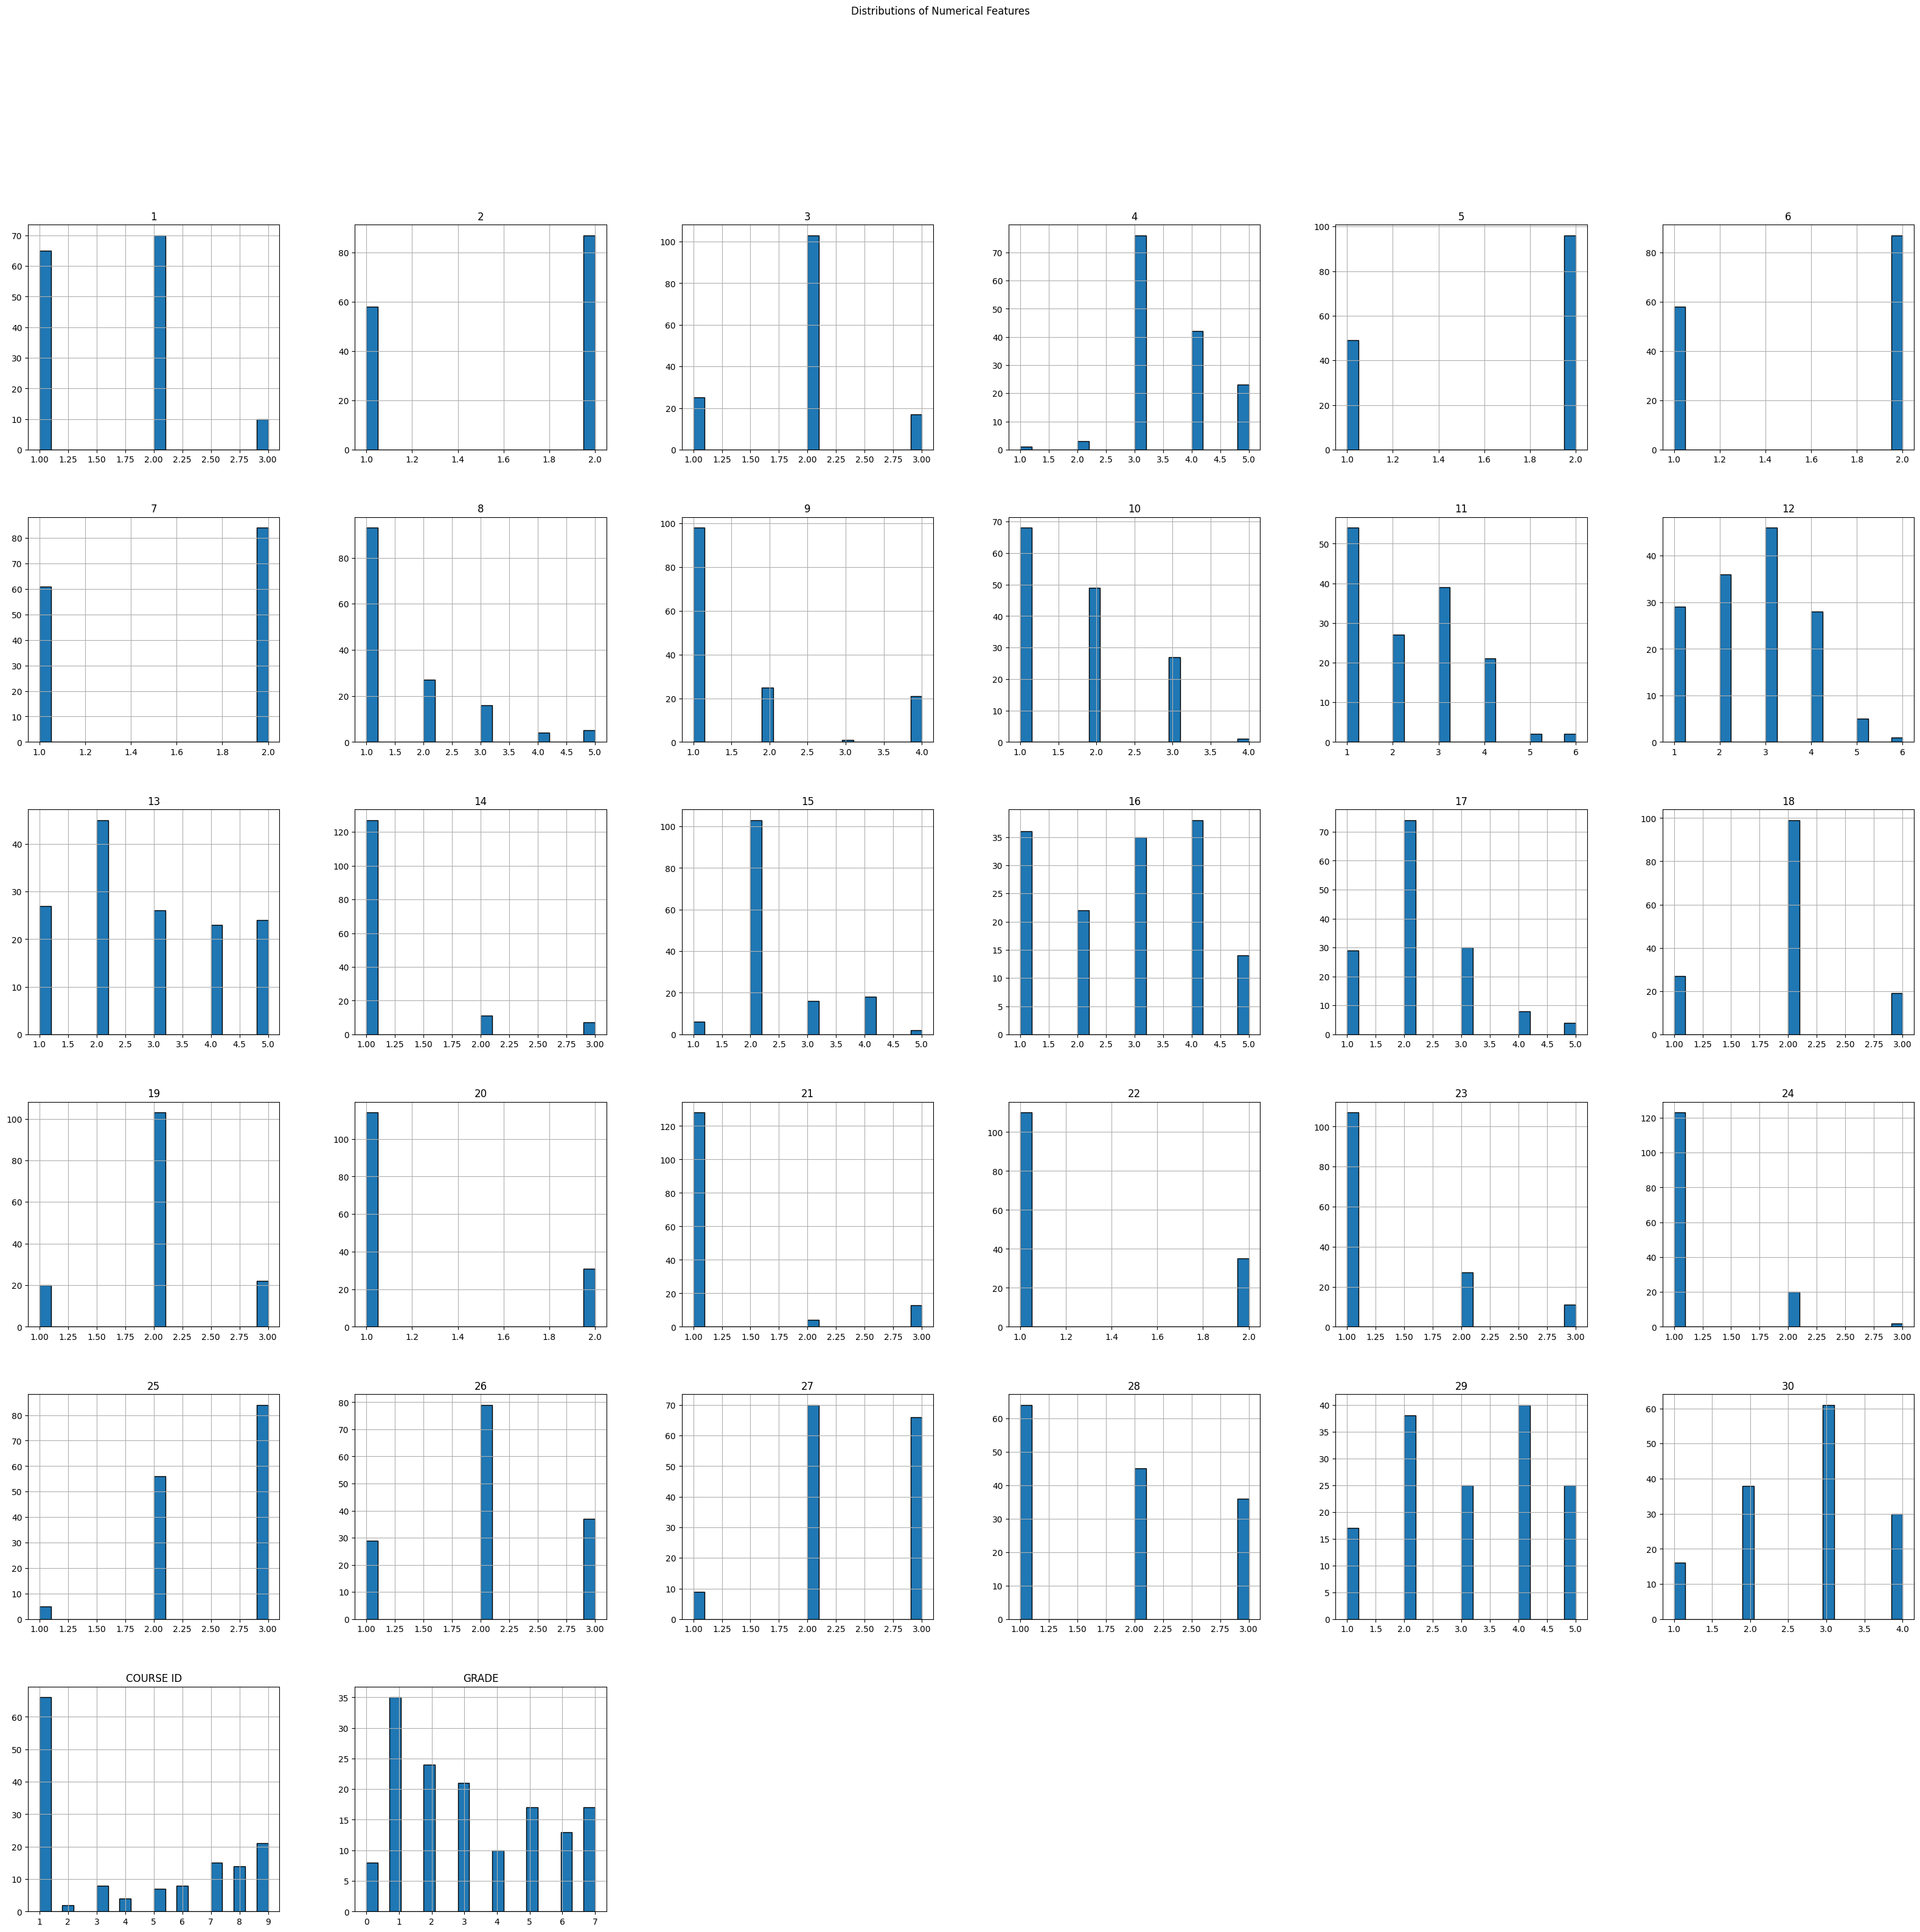

In [ ]:
# To visualize distributions of numerical features
import matplotlib.pyplot as plt

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(100, 90))
df[numerical_columns].hist(bins=20, figsize=(40, 36), edgecolor='black')
plt.suptitle('Distributions of Numerical Features')
plt.show()

This function calculates a total score based on the weighted combination of current GPA and average course grades. It then compares this score to the major-specific GPA threshold to determine the admission decision variable a_original

In [ ]:
import numpy as np

# In this example function, we used optimized_weights to represent the weights we will obtain
# through the optimization process. The purpose is to emphasize that the decision-making process considers
# a weighted combination of the current GPA and the average of course grades.

def compute_admission_decision(current_gpa, course_grades, weights, num_of_offer):
    # compute weighted combination of current GPA and course grades
    total_score = weights[0] * current_gpa + weights[1] * np.average(course_grades)

    top_guys = total_score.argsort()[::-1][:num_of_offer]

    a = np.zeros_like(total_score)
    a[top_guys] = 1

    return a

For pipeline, we would like to use the same function each time we process a new dataset into individual variables: x-data features, y-future outcomes, z-features that bring bias to the decision, a-past decisions.\
In this dataset: \
y corresponds to column 30 "Expected Cumulative grade point average in the graduation"; \
z corresponds to column 2 "Sex" and column 31 "Course ID"; \
a is our decision based on "Cumulative grade point average in the last semester" in column 29 and "Cumulative grade point average in the last semester" in column 32 "OUTPUT Grade", where 1 means "Accepted" and 0 means "Rejected"; \
x is all the other characteristics left in the data after separating z and y.

In [ ]:
def pipeline(df, current_GPA_index, current_Grades_index, expected_GPA_index, bias_feature_index):
  x_origin = df.copy()

  # Extract 'y' - the expected cumulative GPA upon graduation
  y = x_origin.iloc[:, expected_GPA_index].astype(float)

  z = x_origin.iloc[:, bias_feature_index]  # Selecting the 2nd and 31st columns

  # Extract 'x' - all other characteristics
  x = x_origin.drop(x_origin.columns[bias_feature_index], axis=1)
  x = x_origin.drop(x_origin.columns[expected_GPA_index], axis=1)

  # Now, get the original a
  weights = np.array([0.8, 0.2])
  num_of_offer = 80
  current_gpa = x_origin.iloc[:, current_GPA_index]
  course_grades = x_origin.iloc[:, current_Grades_index]
  a_origin = compute_admission_decision(current_gpa, course_grades, weights, num_of_offer)

  return x_origin, x, y, z, a_origin

In [ ]:
# You can define the variables as you like
current_GPA_index = 29
current_Grades_index = 32
expected_GPA_index = 30
# choose bias feature
gender = 2
course_id = 31
bias_feature_index = [gender, course_id]

In [ ]:
# Now you can use this pipeline to deal with all datasets.
x_origin, x, y, z, a_origin = pipeline(df, current_GPA_index, current_Grades_index, expected_GPA_index, bias_feature_index)

For reproducible, refer to the textbook starting on page 61 to refine the code.\
Typical methods such as recording the random seed while doing RP, or fixing the random seed at the beginning.\
We can also find some other datasets and analyze them to see if our algorithm is reproducible as well as robust.

In [ ]:
# a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
# Now, any subsequent random processes using NumPy will produce the same results
# Setting a seed ensures that these random operations produce the same results each time the code is run.

## 2. Privacy: Identify potential privacy issues in the data.
This includes protecting individuals in the data set (if talking about a static analysis), or users during system deployment (if talking about a deployed system). \
Choose one or two suitable methods that formally protect privacy (any variant of DP is good, but k-anonymity provides no formal guarantees) and see how maintaining privacy affects performance of your analysis.

Based on the attributes provided in the dataset, there are several potential privacy issues to consider:

1. **Student ID:** This is a unique identifier and should be handled carefully to avoid re-identification risks. Any analysis or publication should be performed without exposing individual student IDs.

2. **Age and Gender:** While age and gender are often collected for statistical purposes, they can still be considered sensitive information. Aggregating age ranges rather than providing specific ages can help mitigate this.

3. **Financial Information:** Attributes such as total salary, scholarship type, and parental status may reveal financial details about the students or their families, introducing privacy concerns.

4. **Family Information:** The number of siblings, parents' education, parents' occupation, and parental status can collectively provide a detailed profile of the students' family, potentially compromising privacy.

5. **Residential and Transportation Information:** Accommodation type and transportation method can indirectly reveal a student's location, which may be sensitive information.

6. **Educational History:** Details about parents' education and students' past educational experiences can be sensitive and contribute to re-identification risks.

7. **Study Habits and Performance:** Weekly study hours, reading frequency, attendance to classes, and performance-related attributes can collectively provide insights into a student's study habits and academic performance, potentially impacting privacy.

8. **Personal Habits:** Attributes related to personal habits, such as attendance to seminars, impact of projects on success, and preparation for exams, may reveal information about students' preferences and behaviors.

In [ ]:
df_privacy = df.copy().convert_dtypes()

### k-Anonymity

In [ ]:
def is_k_anonymized(df, k):
    for index, row in df.iterrows():
        conditions = []
        for col in df.columns:
            if df[col].dtype == pd.StringDtype():
                conditions.append(f'`{col}` == "{row[col]}"')
            else:
                conditions.append(f'`{col}` == {row[col]}')
        query = ' & '.join(conditions)
        rows = df.query(query, engine='python')
        if rows.shape[0] < k:
          return False
    return True

def check_k_anonymized(df, ks=11):
    for i in range(1, ks):
        print(f'k = {i}: {is_k_anonymized(df, i)}')

In [ ]:
check_k_anonymized(df_privacy)

k = 1: True
k = 2: False
k = 3: False
k = 4: False
k = 5: False
k = 6: False
k = 7: False
k = 8: False
k = 9: False
k = 10: False


### De-identification

In [ ]:
df_dei = df_privacy.copy().drop(columns=['STUDENT ID'])
check_k_anonymized(df_dei)

k = 1: True
k = 2: False
k = 3: False
k = 4: False
k = 5: False
k = 6: False
k = 7: False
k = 8: False
k = 9: False
k = 10: False


When k = 1 the result is True and for higher values of k it is False. So, it implies that each individual in our dataset is uniquely identifiable based on the specified attributes. In other words, there is no other record in the dataset that shares the same combination of values for the considered attributes. For k > 1, it means that each record should be indistinguishable from at least (k - 1) other records. In our case, when k is greater than 1, it indicates that there is no group of records sharing the same combination of attribute values.

### Randomized Response
Randomized Response is suitable for binary or categorical attributes.
Introduces random noise to the true value through a controlled randomization process.
It is used when dealing with sensitive binary attributes, and the goal is to protect individual privacy while still obtaining aggregate statistics. In our dataset, we just have categorical data, so we use Randomized Response for privacy.

In [ ]:
def randomized_response(true_data, probability_of_truth, num_samples):
    """
    Apply Randomized Response to binary data like for example Gender.
    Gender has two values 1 for female and 2 for male
    """
    # Generate random responses based on the true data and probability of truth
    observed_responses = np.random.choice([0, 1], size=num_samples, p=[1 - probability_of_truth, probability_of_truth])
    observed_responses = np.where(observed_responses == 1, true_data, observed_responses)

    return observed_responses

In [ ]:
def randomized_response(df, attributes, noise_probability):
    """
    This method is a form of generalization of the randomized response technique for categorical data
    for example for data like Mothers occupation: (1: retired, 2: housewife, 3: government officer,
    4: private sector employee, 5: self-employment, 6: other) we have 6 different values
    """
    randomized_responses = df.copy()

    for attribute in attributes:
        column = df[attribute]
        randomized_responses[attribute] = np.where(
            np.random.rand(len(df)) < noise_probability,
            np.random.choice(column.unique(), len(df)),
            column
        )

    return randomized_responses


## 3. Fairness: Identify potential fairness issues.
Measure one or more types of fairness inherent in the data itself or your model/algorithm (e.g. a classifier, if that is your project's task). \
Finally, implement a mechanism to mitigate one type of fairness, time-permitting.

Here, let's assume a problem: based on the student's current grades (current GPA as well as grades in each course) - x, and expected future GPA - y, determine whether the school should or should not give the student a master offer --a. \
If the offer is given according to individual academic performance which is the student's existing GPA as well as the grades in each course, then we stipulate: only those with an existing GPA of 4 or above will be considered; at the same time, there is a limit on the number of admission quota: only m students can be admitted, then we further stipulate: when the GPAs are the same, the higher the grades in the courses the higher the student will be admitted. This gives us the initial decision result - a_original. \
$\pi_0(a_t | x_t, z_t)$\
This decision result is clearly irrational - because the GPAs of people in different majors are given by instructors in different courses, and the distribution of grades given by individual instructors is disparate, with some instructors giving relatively high grades and others lower; also, comparing course grades when the GPAs are the same is irrational, because different courses are not of the same difficulty and cannot be measured by a single evaluation criterion. So next we want to optimize this policy. \

### Group Fairness
For Group Fairness, here are a few bias features that need to be balanced: the first is gender - for example, the textbook mentions that some high school teachers discourage girls from studying math; the second is majors - some majors' course grades have means and medians that are are significantly greater than course grades in other majors, which can lead to relatively higher GPAs in those majors. These can be categorized into different groups-z, which we expect to satisfy the following formula also known as Equality of Opportunity:\
$P^{\pi}_{\theta}(a_t | z_t) = P^{\pi}_{\theta}(a_t)$. \
Meanwhile, for Demographic Parity, we want it to satisfy the following equation: \
$P^{\pi}_{\theta}(y_t | z_t) = P^{\pi}_{\theta}(y_t)$. \
For Calibration, we want it to satisfy the following equation: \
$P^{\pi}_{\theta}(y_t | a_t, z_t) = P^{\pi}_{\theta}(y_t | a_t)$. \
For Balance, we want it to satisfy the following equation:\
$P^{\pi}_{\theta}(a_t | y_t, z_t) = P^{\pi}_{\theta}(a_t | y_t)$. \

For the Utility function, I have considered using the following function:\
$U(a, y) = (a-\frac{y}{y_{max}})^2$\
This function shows that as the expected GPA of the admitted student gets higher, the function takes on a smaller value, in which case we want U to be as small as possible. But this function is used to solve regression problems but action is a boolean value that represents a judgement rather than a probability, using the above utility function would make action become a prediction of the student's future performance rather than a judgement of whether or not to give the student an offer.\
Instead, we use this:\
$U(a, y) = a(y-threshold)$, where $threshold = 3.5$\
For the Fairness function, since we know that strict independent uncorrelation is hard to exist in practice, we use the following function: \
$F(a, y) = (P^{\pi}_{\theta}(a_t | y_t, z_t) - P^{\pi}_{\theta}(a_t | y_t))^2$\
In this case we want F to be as small as possible. Note that $P^{\pi}_{\theta}(a_t | y_t, z_t)$ here is just an example, in fact we will compute the four independent irrelevant conditions mentioned above. \
We can then use Unconstrained optimisation and the set $\lambda$ to construct the objective function as well as optimize it: \
$\min_{\pi} -(1 - \lambda)U(\pi, \theta) + \lambda F(\pi, \theta)$\
where, for x, y, z, a, we make no changes, and the only goals we optimize are the trainable weights $w$ and $b$ in the new policy function:\
$\pi(a | x, z) = 1 / (1+e^{-(wx + bz)}) where >=0.9$\
After obtaining the new POLICY function in this way, we can make more FAIRNESS predictions for all students in the next enrollment.

#### First, define the new policy function, π(a∣x, z)= wx + bz where w and b are trainable weights.

In [ ]:
import numpy as np
from scipy.optimize import minimize


def policy_function(x, z, w, b):

    u = np.dot(x, w) + np.dot(z, b)
    # If normalisation and rounding is done here, then backpropagation of the gradient is not possible and the parameters cannot be updated.

    # # use logistic function to get a value between 0-1 and culculate the propability when it equal to 1.
    # policy = sigmoid(u) # only use sigmoid will cause gradient disappear

    policy = layer_norm(u)
    policy = sigmoid(policy)

    a  = np.where(policy >= 0.5, 1, 0)
    a = np.array(a)

    # print('b: ', b)
    # print('u: ', u[:10])
    # print('policy: ', policy[:10])
    # print("a: ", a[:10])

    return a, policy

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def layer_norm(x):
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - mean) / (std + 1e-5)

def relu(x):
    return np.maximum(0, x)

In [ ]:
# Then define the utility function
def utility_function(a, policy, y):
    # we should first find y_max in y column
    y_max = float(max(y))
    # notice! if a=0, means we reject this student, so y should equal to 0 as well.
    utility = np.zeros(len(a))
    for i in range(len(a)):
      # if a[i]==0:
      #   utility[i] = 0.0;
      # else:
      #   # utility[i] = (policy[i] - y[i] / y_max) ** 2
      #   # utility[i] = (a[i] - y[i]) ** 2
      #   utility[i] = 4*policy[i] - y[i]

      #  give a threshold, if a=0, utility is zero, else equal to (y[i] - threshold)
      threshold = 3.5
      utility[i] = policy[i] * (y[i] - threshold)

    # new policy

    return np.sum(utility)

We first need to calculate the probabilities, pay attention that: in this situation, we have two bias features-Gender and CouseID, so we need to analyse values of z one by one(means that you can choose a bunch of bias features and optimize them at the same time.)

In [ ]:
def calculate_probabilities(x, y, z, a):

    # print(x.shape, y.shape, z.shape, a.shape)
    probabilities = {}

    df = pd.DataFrame({'a': a.flatten(), 'y': y.flatten()})
    for i in range(z.shape[1]):
        df[f'z{i}'] = z[:, i]

    probabilities['a'] = df['a'].value_counts(normalize=True)
    probabilities['y'] = df['y'].value_counts(normalize=True)

    # z in each column
    for i in range(z.shape[1]):
        probabilities[f'z{i}'] = df[f'z{i}'].value_counts(normalize=True)

    # probabilities[a, z]
    for i in range(z.shape[1]):
        probabilities[f'a, z{i}'] = df.groupby(f'z{i}')['a'].value_counts(normalize=True)
        # We can have a look
        # print(probabilities[f'a, z{i}'])

    # probabilities[y, z]
    for i in range(z.shape[1]):
        probabilities[f'y, z{i}'] = df.groupby(f'z{i}')['y'].value_counts(normalize=True)

    # probabilities[y, a, z]
    for i in range(z.shape[1]):
        probabilities[f'y, a, z{i}'] = df.groupby(['a', f'z{i}'])['y'].value_counts(normalize=True)

    # probabilities[y, a]
    probabilities['y, a'] = df.groupby('a')['y'].value_counts(normalize=True)

    # probabilities[a, y, z]
    for i in range(z.shape[1]):
        probabilities[f'a, y, z{i}'] = df.groupby(['y', f'z{i}'])['a'].value_counts(normalize=True)

    # probabilities[a, y]
    probabilities['a, y'] = df.groupby('y')['a'].value_counts(normalize=True)

    return probabilities

About fairness function, I want to use Unconstrained optimisation so I fused four constraint terms that need to be balanced into Fairness fuction:

In [ ]:
# Next, define fairness function
def fairness_function(z, probabilities, theta):
    equality_opportunity = 0
    demographic_parity = 0
    calibration = 0
    balance = 0

    for i in range(z.shape[1]):
        for z_value in probabilities[f'z{i}'].index:

            # Equality of Opportunity
            if z_value in probabilities[f'a, z{i}']:
                prob_a_given_z = probabilities[f'a, z{i}'][z_value]
                prob_a = probabilities['a']
                eo = prob_a_given_z - prob_a
                equality_opportunity += np.sum(eo ** 2)

            # Demographic Parity
            if z_value in probabilities[f'y, z{i}']:
                prob_y_given_z = probabilities[f'y, z{i}'][z_value]
                prob_y = probabilities['y']
                dp = prob_y_given_z - prob_y
                demographic_parity += np.sum(dp ** 2)

            # Calibration
            if z_value in probabilities[f'y, a, z{i}']:
                prob_y_given_a_z = probabilities[f'y, a, z{i}'][z_value]
                prob_y_given_a = probabilities['y, a']
                cal = prob_y_given_a_z - prob_y_given_a
                calibration += np.sum(cal ** 2)

            # Balance
            if z_value in probabilities[f'a, y, z{i}']:
                prob_a_given_y_z = probabilities[f'a, y, z{i}'][z_value]
                prob_a_given_y = probabilities['a, y']
                bal = prob_a_given_y_z - prob_a_given_y
                balance += np.sum(bal ** 2)

    # print(equality_opportunity, demographic_parity, calibration, balance)
    # Sum of squared differences
    fairness = equality_opportunity + demographic_parity + calibration + balance

    # We can also use some weights to balance the fairness
    fairness_balanced = theta[0]*equality_opportunity + theta[1]*demographic_parity + theta[2]*calibration + theta[3]*balance

    # Pareto frontier

    return fairness_balanced


In [ ]:
# Objective function
def objective_function(params, x, z, y, lambda_val, theta, only_U):

    w, b = params[:x.shape[1]], params[x.shape[1]:]
    a, policy = policy_function(x, z, w, b)

    # we now can culculate probabilities dictionary using this a
    probabilities = calculate_probabilities(x, y, z, a)
    # print(probabilities[f'a, z0'])

    U = - utility_function(a, policy, y)

    F = fairness_function(z, probabilities, theta)

    #Ablation experiment
    if only_U:
      objective_result = U
    else:
      objective_result = (1 - lambda_val) * U + lambda_val * F

    print('F: ', lambda_val * F, 'U: ', (1 - lambda_val) * U, 'objective_result: ', objective_result)

    return objective_result

In [ ]:
# Optimization
def optimize_policy(x, z, y, lambda_val, theta, only_U):
    initial_params = np.random.rand(x.shape[1] + z.shape[1])
    # if we want to train lamda and theta, we can add it to initial_params, here we just fix their values.
    result = minimize(objective_function, initial_params, args=(x, z, y, lambda_val, theta, only_U))
    return result.x  # Optimized weights

In [ ]:
lambda_val = 0.6
theta = [0.25, 0.5, 0.25, 0.4]
only_U = True

x_array = x.drop(x.columns[0], axis=1)
x_array = np.array(x_array, dtype=float)
z_array = np.array(z, dtype=float)
y_array = np.array(y, dtype=float)
result = optimize_policy(x_array, z_array, y_array, lambda_val, theta, only_U)

if only_U:
  result = np.array(result)
  np.save('result_only_U.npy', result)
else:
  result = np.array(result)
  np.save('result_of_group_fairness.npy', result)

F:  8.387209355895012 U:  20.65356612181334 objective_result:  51.633915304533346
F:  8.387209355895012 U:  20.653566119390664 objective_result:  51.63391529847666
F:  8.387209355895012 U:  20.653566117423566 objective_result:  51.63391529355891
F:  8.387209355895012 U:  20.653566121788874 objective_result:  51.63391530447218
F:  8.387209355895012 U:  20.653566117268866 objective_result:  51.633915293172166
F:  8.387209355895012 U:  20.65356612166953 objective_result:  51.633915304173826
F:  8.387209355895012 U:  20.653566122161273 objective_result:  51.63391530540318
F:  8.387209355895012 U:  20.653566122323117 objective_result:  51.63391530580779
F:  8.387209355895012 U:  20.653566123099235 objective_result:  51.63391530774808
F:  8.387209355895012 U:  20.653566121332986 objective_result:  51.63391530333246
F:  8.387209355895012 U:  20.65356612238745 objective_result:  51.63391530596862
F:  8.387209355895012 U:  20.65356612664067 objective_result:  51.633915316601666
F:  8.3872093558

Now we can use this weight of new policy to give new dicision on every students.

In [ ]:
def get_a(result, x, z):
    w, b = result[:x.shape[1]], result[x.shape[1]:]
    a_new, _ = policy_function(x, z, w, b)
    return a_new

Now, visualize action with bias feature


In [ ]:
Bias_Gender = z['2'].to_numpy()
Bias_CourseID = z['COURSE ID'].to_numpy()

count_bias_gender_1 = np.sum(Bias_Gender == 1)
count_bias_gender_2 = np.sum(Bias_Gender == 2)

balance_times = count_bias_gender_1/count_bias_gender_2

result = np.load('result_only_U.npy')
# print(result)
a_U_only = get_a(result, x_array, z_array)
a_U_only = np.array(a_U_only)

result = np.load('result_of_group_fairness.npy')
# print(result)
a_U_F = get_a(result, x_array, z_array)
a_U_F = np.array(a_U_F)

# print(a_U_only)
# print(a_U_F)

In [ ]:
import matplotlib.pyplot as plt

def count_occurrences_binary(action, Bias_Gender, balance_times):
    counts = {0: [0, 0], 1: [0, 0]}

    # print(action)
    for i, value in enumerate(action):
        gender_id = Bias_Gender[i] - 1
        counts[value][gender_id] += 1
        # print('gender_id: ', gender_id, ' value: ', value, ' counts: ', counts)

    # for key in counts:
    #     counts[key][0] = int(counts[key][0]/balance_times)

    return counts

# Count occurrences for a_U_only and a_U_F

counts_a_U_only = count_occurrences_binary(a_U_only, Bias_Gender, balance_times)
counts_a_U_F = count_occurrences_binary(a_U_F, Bias_Gender, balance_times)

print(counts_a_U_only, counts_a_U_F)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for a_U_only
axes[0].bar([0, 1], counts_a_U_only[0], width=0.4, label='reject', align='center')
axes[0].bar([0.4, 1.4], counts_a_U_only[1], width=0.4, label='accept', align='center')
axes[0].set_title('Counts of Bias_Gender for a_U_only')
axes[0].set_xticks([0.2, 1.2])
axes[0].set_xticklabels(['Gender 1', 'Gender 2'])
axes[0].set_ylabel('Count')
axes[0].legend()

# Bar plot for a_U_F
axes[1].bar([0, 1], counts_a_U_F[0], width=0.4, label='reject', align='center')
axes[1].bar([0.4, 1.4], counts_a_U_F[1], width=0.4, label='accept', align='center')
axes[1].set_title('Counts of Bias_Gender for a_U_F')
axes[1].set_xticks([0.2, 1.2])
axes[1].set_xticklabels(['Gender 1', 'Gender 2'])
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

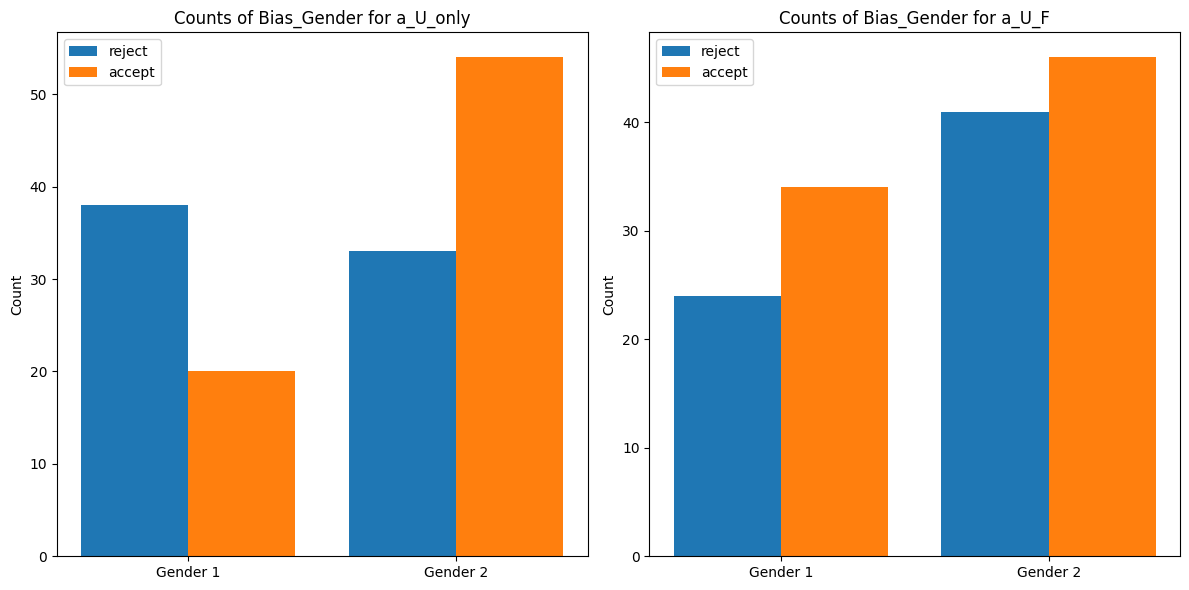

### Individual Fairness
For Individual Fairness, we mentioned before that "when GPAs are the same, students with higher course grades will be admitted" is not reasonable.
So we want to consider all aspects of a student to make the decision smoother.

Treating similar individuals similarly:\
$\max_{\pi} U({\pi})$\
${s.t. } D[\pi(a_i|x_i), \pi(a_j|x_j)] \leq d(x_i, x_j).$\
The main idea is to add this constraint to current optimization function.


In [ ]:
from scipy.optimize import minimize, NonlinearConstraint

def constraint_function(params, x, z, y, epsilon):
    w, b = params[:x.shape[1]], params[x.shape[1]:]
    a, policy = policy_function(x, z, w, b)

    D_values = []
    for i in range(0, len(policy) - 1, 2):
        D_value = np.abs(policy[i] - policy[i+1])
        d_value = np.abs(y[i] - y[i+1])
        D_values.append(D_value - epsilon*d_value)
        # print(D_value, d_value)

    print('max(D_values): ', max(D_values), ' min(D_values): ', min(D_values))

    return D_values

def optimize_policy_with_individualFairness(x, z, y, lambda_val, theta, only_U, epsilon, ori_result=None):
    if ori_result is None:
        print("random initialize")
        initial_params = np.random.rand(x.shape[1] + z.shape[1])
    else:
        print("loading pretrained")
        initial_params = ori_result

    constraint = NonlinearConstraint(lambda params: constraint_function(params, x, z, y, epsilon), lb=-np.inf, ub=0)
    result = minimize(objective_function, initial_params, args=(x, z, y, lambda_val, theta, only_U), constraints=[constraint])

    return result.x

In [ ]:
lambda_val = 0.6
epsilon  = 0.5
theta = [0.25, 0.5, 0.25, 0.4]
only_U = False

x_array = x.drop(x.columns[0], axis=1)
x_array = np.array(x_array, dtype=float)
z_array = np.array(z, dtype=float)
y_array = np.array(y, dtype=float)

ori_result = np.load('result_of_group_fairness.npy')
individual_result = optimize_policy_with_individualFairness(x_array, z_array, y_array, lambda_val, theta, only_U, epsilon, ori_result)

individual_result = np.array(individual_result)
np.save('result_individual.npy', individual_result)

Streaming output truncated to the last 5000 lines.
F:  8.716406104642887 U:  22.08399000868793 objective_result:  30.80039611333082
F:  8.716406104642887 U:  22.083990008743335 objective_result:  30.80039611338622
F:  8.716406104642887 U:  22.083990008695352 objective_result:  30.800396113338238
F:  8.716406104642887 U:  22.083990008749133 objective_result:  30.80039611339202
F:  8.716406104642887 U:  22.08399000860002 objective_result:  30.800396113242904
F:  8.716406104642887 U:  22.083990008663314 objective_result:  30.8003961133062
F:  8.716406104642887 U:  22.08399000883777 objective_result:  30.80039611348066
F:  8.716406104642887 U:  22.083990009083028 objective_result:  30.800396113725917
F:  8.716406104642887 U:  22.08399000849156 objective_result:  30.800396113134447
F:  8.716406104642887 U:  22.083990008513823 objective_result:  30.800396113156708
F:  8.716406104642887 U:  22.083990008656016 objective_result:  30.800396113298902
F:  8.716406104642887 U:  22.083990008505964 o

In [ ]:
# Count occurrences for a_U_only and a_U_F

result = np.load('result_of_group_fairness.npy')
a_U_F = get_a(result, x_array, z_array)
a_U_F = np.array(a_U_F)

result = np.load('result_individual.npy')
a_Individual = get_a(result, x_array, z_array)
a_Individual = np.array(a_Individual)

# print(a_U_F)
# print(a_Individual)

counts_a_U_F = count_occurrences_binary(a_U_F, Bias_Gender, balance_times)
counts_a_Individual = count_occurrences_binary(a_Individual, Bias_Gender, balance_times)

print(counts_a_U_F, counts_a_Individual)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for a_U_only
axes[0].bar([0, 1], counts_a_U_F[0], width=0.4, label='reject', align='center')
axes[0].bar([0.4, 1.4], counts_a_U_F[1], width=0.4, label='accept', align='center')
axes[0].set_title('Counts of Bias_Gender for a_U_F')
axes[0].set_xticks([0.2, 1.2])
axes[0].set_xticklabels(['Gender 1', 'Gender 2'])
axes[0].set_ylabel('Count')
axes[0].legend()

# Bar plot for a_U_F
axes[1].bar([0, 1], counts_a_Individual[0], width=0.4, label='reject', align='center')
axes[1].bar([0.4, 1.4], counts_a_Individual[1], width=0.4, label='accept', align='center')
axes[1].set_title('Counts of Bias_Gender for a_Individual')
axes[1].set_xticks([0.2, 1.2])
axes[1].set_xticklabels(['Gender 1', 'Gender 2'])
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

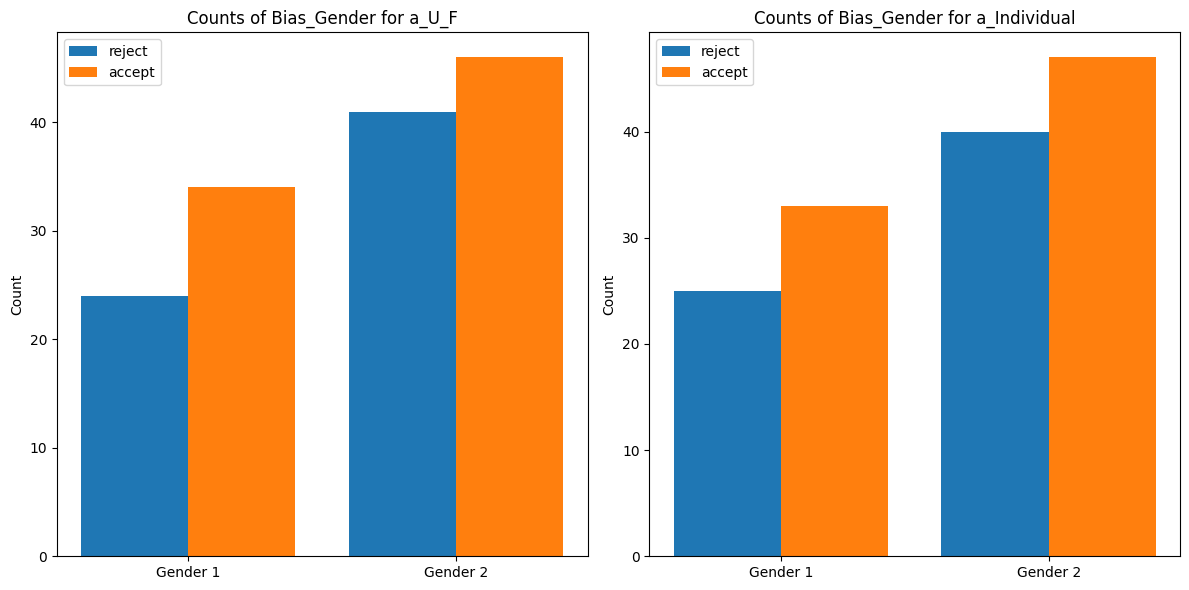

## Pipline

### Defining pipeline for trainig our Machine learning model:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# the following function applies Randomized Response to the categorical attributes
def randomized_response(df, attributes, noise_probability):
    randomized_responses = df.copy()

    for attribute in attributes:
        column = df[attribute]
        randomized_responses[attribute] = np.where(
            np.random.rand(len(df)) < noise_probability,
            np.random.choice(column.unique(), len(df)),column)

    return randomized_responses

# compute admission decisions
def compute_admission_decision(current_gpa, course_grades, weights, num_of_offer):
    total_score = weights[0] * current_gpa + weights[1] * np.average(course_grades)
    top_guys = total_score.argsort()[::-1][:num_of_offer]
    a = np.zeros_like(total_score)
    a[top_guys] = 1
    return a

# train the model. we use Random forest for classification
def train_model(X_train, y_train):
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    return classifier

# evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    conf_matrix = pd.DataFrame(cm)
    plt.figure(figsize=(4,4))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=False, cmap="Blues")
    plt.title("Confusion Map")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.show()

# pipeline for training the dataset
def main_pipeline(df, admission_labels, applying_randomised_response, sensitive_attributes = ['1','2'], noise_probability = 0.2, test_size=0.2, random_state=42):
  if applying_randomised_response:
    # first we pply Randomized Response to the sensitive attributes
    randomized_df = randomized_response(df, sensitive_attributes, noise_probability)
    # Substitute the values of randomized_df in the df
    df[sensitive_attributes] = randomized_df[sensitive_attributes]

    # split the dataset into training and testing sets: 80% for training 20% for testing
  X_train, X_test, y_train, y_test = train_test_split(df, admission_labels, test_size=0.2, random_state=random_state)

  model = train_model(X_train, y_train)

  evaluate_model(model, X_test, y_test)

  # Cross-validation with cv=5
  scores = cross_val_score(model, df, admission_labels, cv=5)
  print(f"Cross Validation Scores: {scores}")
  print(f"Average Cross Validation Accuracy: {np.mean(scores)}")


After computing the admission labels using group fairness and optimising the objective function, we apply the Random forest classifier to our data.

Accuracy: 0.7241379310344828
Confusion Matrix:
[[11  3]
 [ 5 10]]


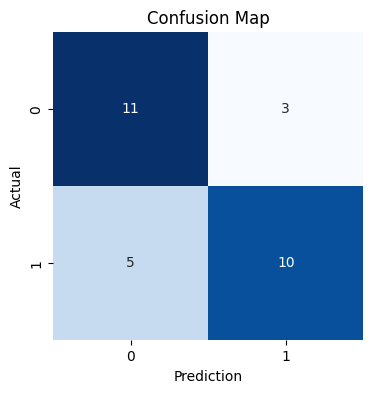

Cross Validation Scores: [0.86206897 0.86206897 0.82758621 0.79310345 0.65517241]
Average Cross Validation Accuracy: 0.8


In [ ]:
df = df.drop('STUDENT ID', axis=1)
# we get the admission labels after computing the group fairness and optimizing the objective function in the previous section
admission_labels = a_U_F

main_pipeline(df, admission_labels, applying_randomised_response = False)

Most research on fairness in Machine Learning assumes the relationship between fairness and accuracy to be a trade-off, with an increase in fairness leading to an unavoidable loss of accuracy. The fairness-utility trade-off is an important concept in the algorithmic fairness literature. It states that when some notion of fairness is enforced then usually the accuracy (or 'utility') suffers. In our project, after applying group fairness, the accuracy decreased to 0.72, while before applying the group fairness, the accuracy wa 0.96

Accuracy: 0.896551724137931
Confusion Matrix:
[[10  2]
 [ 1 16]]


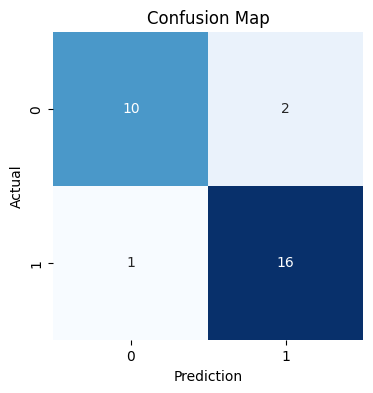

Cross Validation Scores: [0.89655172 0.93103448 0.89655172 0.86206897 0.89655172]
Average Cross Validation Accuracy: 0.8965517241379309


In [ ]:
# sensitive attributes that need Randomized Response
# column 1: Age
# column 2: gender
# Age and gender, when combined with other attributes, can contribute to the identification of individuals.
# column 8: Total salary: reavels information about the family status of students
# column 9: Transportation to the university: reavels information about the location of students
# column 11: Mothers education: reavels information about the family status of students
# column 12: Fathers education: reavels information about the family status of students
# column 14: Parental status: reavels information about the family status of students
# column 31: Course ID: reavels information about the academic pursuit status of students
sensitive_attributes = ['1','2', '8', '9','11', '12', '14', '31']

# pipeline parameters
noise_probability = 0.2

num_of_offer = 80

weights = np.array([0.8, 0.2])

admission_labels = compute_admission_decision(df['29'], df['30'], weights, num_of_offer)

main_pipeline(df, admission_labels, applying_randomised_response = True)

After applying randomized response to our data, the accuracy decreased. The decrease in machine learning accuracy after applying randomized response can be attributed to the noise introduced during the randomization process. Randomized response is a privacy-preserving technique that adds randomness to the data to protect individual privacy. While this is beneficial for privacy, it can also have a negative impact on the utility of the data for machine learning tasks.
The following result shows the result of random forest without applying randomized response to our data.

Accuracy: 0.896551724137931
Confusion Matrix:
[[10  2]
 [ 1 16]]


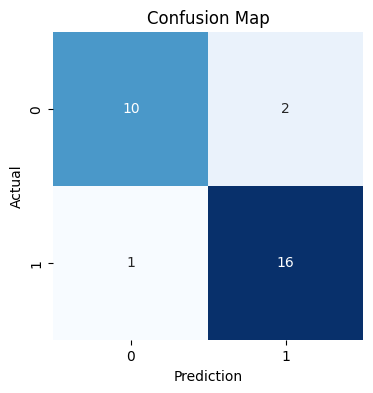

Cross Validation Scores: [0.89655172 0.93103448 0.89655172 0.86206897 0.89655172]
Average Cross Validation Accuracy: 0.8965517241379309


In [ ]:
# pipeline for training the dataset
def main_pipeline(df, weights, num_of_offer, test_size=0.2, random_state=42):

    # Compute admission decisions using the compute_admission_decision function
    admission_labels = compute_admission_decision(df['29'], df['30'], weights, num_of_offer)

    # split the dataset into training and testing sets: 80% for training 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(df, admission_labels, test_size=0.2, random_state=random_state)

    model = train_model(X_train, y_train)

    evaluate_model(model, X_test, y_test)

    # Cross-validation with cv=5
    scores = cross_val_score(model, df, admission_labels, cv=5)
    print(f"Cross Validation Scores: {scores}")
    print(f"Average Cross Validation Accuracy: {np.mean(scores)}")

# pipeline parameters
weights = np.array([0.8, 0.2])
num_of_offer = 80

#df = df.drop('STUDENT ID', axis=1)

main_pipeline(df, weights, num_of_offer)

## References
- [ml-society-science](https://github.com/olethrosdc/ml-society-science)
- [Programming Differential Privacy](https://programming-dp.com/)